In [349]:
import pickle

%pylab inline
import numpy 
import matplotlib.pyplot as plt
import sklearn
# Import all of the scikit learn stuff
from __future__ import print_function, division
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.preprocessing import Normalizer
from sklearn import metrics
from sklearn.cluster import KMeans, MiniBatchKMeans
import pandas as pd
import re
from pprint import pprint

import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.preprocessing import Normalizer
from sklearn.manifold import TSNE
from nltk import word_tokenize 
from sklearn.metrics.pairwise import cosine_similarity

from nltk.stem import WordNetLemmatizer 
from nltk.stem.porter import *
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


In [238]:
posts = pickle.load(open("jobposts2.p", "rb"))


In [200]:
posts.shape

(34453, 8)

In [319]:
posts_no_wiki = posts[~(posts['source']=='wiki')]

In [320]:
docs_no_wiki = posts_no_wiki['desc']

In [239]:
docs_dup_drop = posts['desc']

In [33]:
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = PorterStemmer()
    def __call__(self, doc):
        return [self.wnl.stem(t) for t in word_tokenize(doc)]

In [321]:
#try with no duplicates
tfidf_nodup = TfidfVectorizer(stop_words="english", token_pattern="\\b[a-z][a-z]+\\b", min_df=.002, max_df=0.40)
tfidf_vecs_nodup = tfidf_nodup.fit_transform(docs_no_wiki)
tfidf_jobdesc_nodup = pd.DataFrame(tfidf_vecs_nodup.todense(), columns=tfidf_nodup.get_feature_names())

In [322]:
dropped_docs_nodup = pickle.load(open("dropped_docs.p", "rb"))
dropped_docs_nodup

[2793]

In [323]:
dropped_posts_nodup= docs_no_wiki.reset_index(drop=True).drop(dropped_docs_nodup)
full_posts_nodup= posts_no_wiki.reset_index(drop=True).drop(dropped_docs_nodup)

In [242]:
dropped_posts_nodup= docs_dup_drop.reset_index(drop=True).drop(dropped_docs_nodup)
full_posts_nodup= posts.reset_index(drop=True).drop(dropped_docs_nodup)

In [324]:
full_posts_nodup.shape

(34132, 8)

In [325]:
dropped_posts_nodup.shape

(34132,)

In [326]:
default_stopwords = set(nltk.corpus.stopwords.words('english'))


In [327]:
from sklearn.externals import joblib
joblib.dump(tfidf_nodup, 'tfidf_notitles_vectorizer.pkl' )
joblib.dump(tfidf_jobdesc_nodup, 'tfidf_notitles.pkl' )

['tfidf_notitles.pkl']

In [102]:
skills = ['pipette biology']
tfidf_skills = tfidf_nodup.transform(skills)
sim = cosine_similarity(tfidf_jobdesc_nodup, tfidf_skills)

In [103]:
text = ''
for i in sim.argsort(axis=0)[-10:]:
    #print(dropped_posts_nodup.iloc[i].values)
    text += dropped_posts_nodup.iloc[i].values[0]
    
text = text.split()
text = [word.lower() for word in text]
text = [word for word in text if word not in default_stopwords]
text = [word for word in text if len(word) > 1]


In [104]:
freq= nltk.FreqDist(text)
freq.most_common(10)

[(u'biology', 47),
 (u'research', 41),
 (u'study', 32),
 (u'work', 23),
 (u'biological', 21),
 (u'biologists', 20),
 (u'biology,', 18),
 (u'experience', 15),
 (u'molecular', 15),
 (u'scientists', 14)]

In [105]:
posting_stop_words = set(['experience', 'job', 'work', 'position', 'opportunity', 'perform'
                          'looking', 'ability', 'organization', 'good', 'skills', 'years',
                          'benefits', 'company', 'working', 'worked', 'team', 'able', 'must', 'requirements'])

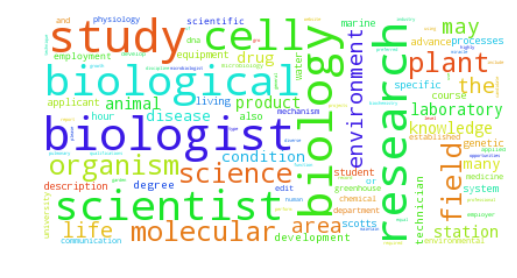

In [106]:
wordcloud = WordCloud(max_font_size=40, max_words=100, stopwords=posting_stop_words, background_color='white').generate(' '.join(text))
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [328]:
lsa = TruncatedSVD(20, algorithm = 'arpack')
dtm_lsa = lsa.fit_transform(tfidf_jobdesc_nodup)
dtm_lsa = Normalizer(copy=False).fit_transform(dtm_lsa)

In [329]:
joblib.dump(lsa, 'lsa_vectorizer.pkl' )
joblib.dump(dtm_lsa, 'lsa_mat.pkl' )

['lsa_mat.pkl']

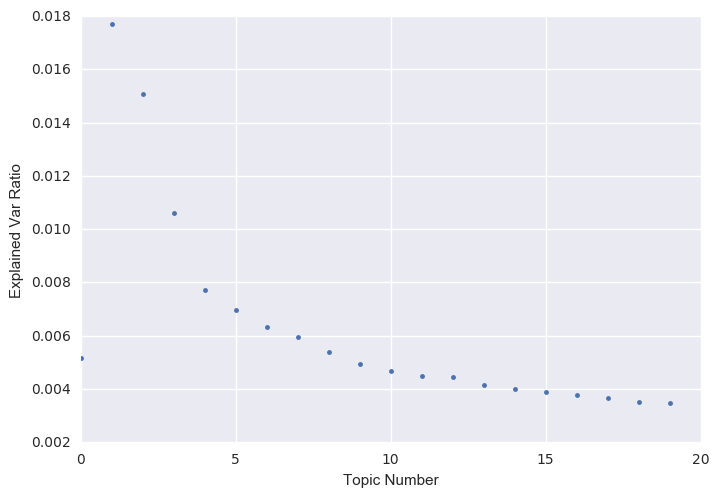

In [354]:
plt.plot(range(len(lsa.explained_variance_ratio_)), lsa.explained_variance_ratio_, '.')
plt.xlabel('Topic Number')
plt.ylabel('Explained Var Ratio')

In [41]:
dropped_posts_nodup.iloc[15966]

u'\nJob Description\n\nRef ID: 00900-9500419340Classification: Account Executive/Staffing ManagerCompensation: $85,000.00 to $150,000.00 per year Join one of the World\'s Most Admired Companies    Job description:   Robert Half Technology, a division of Robert Half International (RHI), is a leading provider of IT professionals on a project and full-time basis. We specialize in initiatives ranging from web development and systems integration to network security and technical support. We are looking for an Account Executive with information technology industry experience to join our team. If you are a self-confident, motivated person with a strong work ethic and excellent communication skills \x96 and you enjoy a fast-paced team-driven environment \x96 we invite you to apply below.   Watch this video to learn more about working at Robert Half Technology: www.roberthalf.com/why-robert-half    As an Account Executive your responsibilities will include:    Developing and growing a client ba

In [351]:
words = np.array(tfidf_nodup.get_feature_names())
set_array = []
for row in lsa.components_:
    top_words_indices = np.argsort(row)[-100:] 
    set_array.append(set(words[top_words_indices]))

    

In [352]:
key_words = []
for job_set in set_array:
    temp_job = job_set
    for job in set_array:
        if job == job_set:
            pass
        else:
            temp_job = temp_job.difference(job)
    key_words.append(temp_job)
            
        

In [353]:
key_words

[{u'assist', u'based', u'field', u'include', u'minimum', u'plan', u'provides'},
 {u'acquisition',
  u'campaign',
  u'consulting',
  u'create',
  u'developing',
  u'events',
  u'existing',
  u'fun',
  u'inside',
  u'outside',
  u'pr',
  u'selling',
  u'success',
  u'teams'},
 {u'accredited',
  u'advancement',
  u'current',
  u'graduate',
  u'human',
  u'licensure',
  u'living',
  u'medication',
  u'outpatient'},
 {u'basic',
  u'cdl',
  u'check',
  u'clean',
  u'cleaning',
  u'conditions',
  u'daily',
  u'diploma',
  u'forklift',
  u'ged',
  u'hand',
  u'heavy',
  u'inspection',
  u'instructions',
  u'lbs',
  u'lift',
  u'machinery',
  u'operate',
  u'operation',
  u'pass',
  u'performing',
  u'plumbing',
  u'pounds',
  u'proper',
  u'read',
  u'safe',
  u'stand',
  u'truck',
  u'trucks',
  u'valid'},
 {u'finding',
  u'interactive',
  u'interested',
  u'mid',
  u'online',
  u'placing',
  u'send',
  u'skilled',
  u'week'},
 {u'approach',
  u'careers',
  u'consider',
  u'dedicated',
  u'de

In [ ]:
model = TSNE(n_components=2)
np.set_printoptions(suppress=True)
tsne_plot = model.fit_transform(dtm_lsa) 

In [110]:
lsa.components_.shape

(20, 7239)

In [343]:
def get_similar_docs(target_vec, corpus_vecs, num_res=5):
    sim_scores = np.dot(target_vec, corpus_vecs.T)
    print(sim_scores[0][np.argsort(-sim_scores)[0][:num_res]])
    return np.argsort(-sim_scores)[0][:num_res]

In [344]:
target_vec = lsa.transform(tfidf_nodup.transform(['programming python java web']))

In [345]:
get_similar_docs(target_vec, dtm_lsa, num_res=5)

[ 0.18852834  0.18781158  0.183779    0.18324291  0.18162018]


array([ 7600,  7594,  7535, 16127,  7638])

In [334]:
full_posts_nodup.iloc[7594]['desc']

u'\nJob Description\n\n\n2+ years developing web applications\nStrong skills with\n\n\nASP.NET\nC#\nKnockout\nJavaScript\njQuery\nLINQ\nSQL Server\n\n\nJob Requirements\n\n\nExperience with:\n\n\nCSS\nJSON\nWeb API\nREST\nAJAX\nWCF\nMicrosoft Report Viewer\n\n\n'

In [335]:
full_posts_nodup['df_ind'] = full_posts_nodup.index

In [336]:
jsondf= full_posts_nodup.iloc[:,2:]

In [337]:
store = jsondf.to_json(orient='index', force_ascii=False)

In [251]:
from pymongo import MongoClient

In [252]:
client = MongoClient()
db = client.jobdescriptiondb
jobmongo = db.jobdesc

In [265]:
store[0:800]

'{"0":{"company":null,"job_url":null,"title":null,"desc":"\\n\\n\\n\\n\\nThis article needs additional citations for verification. Please help improve this article by adding citations to reliable sources. Unsourced material may be challenged and removed. (April 2009) (Learn how and when to remove this template message)\\n\\n\\nA creative director is a position often found within the graphic design, film, music, fashion, advertising, media, or entertainment industries, but may be useful in other creative organizations such as web development and software development firms as well.\\nA creative director is a vital role in all of the arts and entertainment industries. In another sense, they can be seen as another element in any product development process. The creative director may also assume the role'

In [339]:
import json
records = json.loads(store).values()
jobmongo.insert(records)

/Users/James/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: DeprecationWarning: insert is deprecated. Use insert_one or insert_many instead.
  app.launch_new_instance()


[ObjectId('58c1ab158a6818087a847799'),
 ObjectId('58c1ab158a6818087a84779a'),
 ObjectId('58c1ab158a6818087a84779b'),
 ObjectId('58c1ab158a6818087a84779c'),
 ObjectId('58c1ab158a6818087a84779d'),
 ObjectId('58c1ab158a6818087a84779e'),
 ObjectId('58c1ab158a6818087a84779f'),
 ObjectId('58c1ab158a6818087a8477a0'),
 ObjectId('58c1ab158a6818087a8477a1'),
 ObjectId('58c1ab158a6818087a8477a2'),
 ObjectId('58c1ab158a6818087a8477a3'),
 ObjectId('58c1ab158a6818087a8477a4'),
 ObjectId('58c1ab158a6818087a8477a5'),
 ObjectId('58c1ab158a6818087a8477a6'),
 ObjectId('58c1ab158a6818087a8477a7'),
 ObjectId('58c1ab158a6818087a8477a8'),
 ObjectId('58c1ab158a6818087a8477a9'),
 ObjectId('58c1ab158a6818087a8477aa'),
 ObjectId('58c1ab158a6818087a8477ab'),
 ObjectId('58c1ab158a6818087a8477ac'),
 ObjectId('58c1ab158a6818087a8477ad'),
 ObjectId('58c1ab158a6818087a8477ae'),
 ObjectId('58c1ab158a6818087a8477af'),
 ObjectId('58c1ab158a6818087a8477b0'),
 ObjectId('58c1ab158a6818087a8477b1'),
 ObjectId('58c1ab158a6818

In [338]:
appclient = MongoClient(port= 27017, host = '54.201.68.29')
db = appclient.jobdescriptiondb
jobmongo = db.jobapp

In [311]:
jobmongo.find_one({'df_ind': 1000}, {'job_url': 1, 'title': 1})['title'].strip()

u'Production Artist'

In [ ]:
# use with 2grams?